In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

print("="*80)
print("PRE-FCM FEATURE VALIDATION")
print("="*80)

PRE-FCM FEATURE VALIDATION


In [2]:
df = pd.read_csv('/home/kali/AI/fcm_features_raw.csv', index_col=0)  # Update path!


In [3]:
print(f"\nFeature matrix shape: {df.shape}")
print(f"Provinces: {len(df)}")
print(f"Total features: {len(df.columns)}")


Feature matrix shape: (34, 50)
Provinces: 34
Total features: 50


In [4]:
# ============================================================================
print("\n" + "="*80)
print("STEP 1: VARIANCE ANALYSIS")
print("="*80)

feature_variance = df.var().sort_values()

print("\nFeatures with LOWEST variance (top 10):")
print(feature_variance.head(10))

# Flag low-variance features (< 0.01 after standardization would be problem)
low_var_threshold = df.var().quantile(0.05)  # Bottom 5%
low_var_features = feature_variance[feature_variance < low_var_threshold]

print(f"\n⚠️ Low variance features (bottom 5%, n={len(low_var_features)}):")
for feat in low_var_features.index[:5]:
    print(f"  {feat:50s}: var={low_var_features[feat]:.6f}")

if len(low_var_features) > 0:
    print(f"\n⚠️ Recommendation: Consider dropping {len(low_var_features)} low-variance features")


STEP 1: VARIANCE ANALYSIS

Features with LOWEST variance (top 10):
Trend_gula                    6.256207e-10
Trend_Daging_Sapi_Murni       1.561579e-09
Trend_telur_ayam              2.367035e-09
Trend_Daging_Ayam_Ras         3.141084e-09
Trend_bawang_merah            3.502556e-09
Trend_Tepung_Terigu_Curah     6.256503e-09
Trend_beras_premium           6.593770e-09
Trend_Cabai_Merah_Keriting    8.307665e-09
Trend_beras_medium            8.309836e-09
Trend_Bawang_Putih_Bonggol    8.974152e-09
dtype: float64

⚠️ Low variance features (bottom 5%, n=3):
  Trend_gula                                        : var=0.000000
  Trend_Daging_Sapi_Murni                           : var=0.000000
  Trend_telur_ayam                                  : var=0.000000

⚠️ Recommendation: Consider dropping 3 low-variance features


In [5]:
print("\n" + "="*80)
print("STEP 2: CORRELATION ANALYSIS")
print("="*80)

# Calculate correlation matrix
corr_matrix = df.corr()

# Find highly correlated pairs (|r| > 0.8, excluding diagonal)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.8:
            high_corr_pairs.append({
                'Feature_1': corr_matrix.columns[i],
                'Feature_2': corr_matrix.columns[j],
                'Correlation': corr_val
            })

df_high_corr = pd.DataFrame(high_corr_pairs).sort_values('Correlation', ascending=False)

print(f"\nHigh correlation pairs (|r| > 0.8): {len(df_high_corr)}")

if len(df_high_corr) > 0:
    print("\nTop 10 highest correlations:")
    print(df_high_corr.head(10).to_string(index=False))
    
    print("\n⚠️ Redundancy detected! Consider:")
    print("  1. Drop one feature from each highly correlated pair")
    print("  2. Use PCA to reduce dimensionality")
    print("  3. Keep only most interpretable features")



STEP 2: CORRELATION ANALYSIS

High correlation pairs (|r| > 0.8): 25

Top 10 highest correlations:
                    Feature_1                  Feature_2  Correlation
      CV_Bawang_Putih_Bonggol Trend_Bawang_Putih_Bonggol     0.986523
              CV_beras_medium         Trend_beras_medium     0.969085
             CV_beras_premium        Trend_beras_premium     0.966738
Autocorr_Bawang_Putih_Bonggol              Autocorr_gula     0.951173
        Autocorr_beras_medium     Autocorr_beras_premium     0.931569
    Mean_Bawang_Putih_Bonggol                  Mean_gula     0.930360
                      CV_gula                 Trend_gula     0.922999
           Trend_beras_medium        Trend_beras_premium     0.920631
            Mean_beras_medium         Mean_beras_premium     0.910107
    Mean_Bawang_Putih_Bonggol          Mean_bawang_merah     0.903331

⚠️ Redundancy detected! Consider:
  1. Drop one feature from each highly correlated pair
  2. Use PCA to reduce dimensionality
  

In [6]:

# ============================================================================
# STEP 3: FEATURE TYPE ANALYSIS (per feature type)
# ============================================================================
print("\n" + "="*80)
print("STEP 3: FEATURE TYPE ANALYSIS")
print("="*80)

# Group by feature type (Mean, CV, Trend, Autocorr, Skewness)
feature_types = {
    'Mean': [c for c in df.columns if c.startswith('Mean_')],
    'CV': [c for c in df.columns if c.startswith('CV_')],
    'Trend': [c for c in df.columns if c.startswith('Trend_')],
    'Autocorr': [c for c in df.columns if c.startswith('Autocorr_') or c.startswith('AC_')],
    'Skewness': [c for c in df.columns if c.startswith('Skew')]
}

print("\nStatistics per feature type:")
print("-" * 80)
print(f"{'Type':12s} | {'Count':5s} | {'Mean Var':10s} | {'Mean |Corr|':12s} | {'Assessment':20s}")
print("-" * 80)

for ftype, cols in feature_types.items():
    if len(cols) == 0:
        continue
    
    # Variance
    mean_var = df[cols].var().mean()
    
    # Internal correlation (within same feature type across commodities)
    internal_corr = df[cols].corr().abs().values
    mean_internal_corr = internal_corr[np.triu_indices_from(internal_corr, k=1)].mean()
    
    # Assessment
    if mean_var < 0.01:
        assessment = "⚠️ LOW VARIANCE"
    elif mean_internal_corr > 0.7:
        assessment = "⚠️ HIGH REDUNDANCY"
    else:
        assessment = "✓ Good"
    
    print(f"{ftype:12s} | {len(cols):5d} | {mean_var:10.4f} | {mean_internal_corr:12.4f} | {assessment:20s}")





STEP 3: FEATURE TYPE ANALYSIS

Statistics per feature type:
--------------------------------------------------------------------------------
Type         | Count | Mean Var   | Mean |Corr|  | Assessment          
--------------------------------------------------------------------------------
Mean         |    10 | 35524159.0449 |       0.6149 | ✓ Good              
CV           |    10 |     0.0013 |       0.3033 | ⚠️ LOW VARIANCE     
Trend        |    10 |     0.0000 |       0.1966 | ⚠️ LOW VARIANCE     
Autocorr     |    10 |     0.0025 |       0.5992 | ⚠️ LOW VARIANCE     
Skewness     |    10 |     0.1557 |       0.1769 | ✓ Good              


In [7]:
# ============================================================================
# STEP 4: CROSS-TYPE CORRELATION (Mean vs CV, etc)
# ============================================================================
print("\n" + "="*80)
print("STEP 4: CROSS-TYPE CORRELATION MATRIX")
print("="*80)

# Sample one feature from each type for quick check
sample_features = {}
for ftype, cols in feature_types.items():
    if len(cols) > 0:
        sample_features[ftype] = cols[0]  # Take first commodity

df_sample = df[[sample_features[ft] for ft in sample_features.keys()]]
cross_corr = df_sample.corr()

print("\nCross-type correlation (sample - 1st commodity):")
print(cross_corr.round(3))

print("\n⚠️ High cross-correlations (|r| > 0.7):")
found_high = False
for i in range(len(cross_corr.columns)):
    for j in range(i+1, len(cross_corr.columns)):
        corr_val = cross_corr.iloc[i, j]
        if abs(corr_val) > 0.7:
            print(f"  {cross_corr.columns[i]:12s} <-> {cross_corr.columns[j]:12s}: {corr_val:6.3f}")
            found_high = True

if not found_high:
    print("  ✓ None! Feature types are orthogonal.")




STEP 4: CROSS-TYPE CORRELATION MATRIX

Cross-type correlation (sample - 1st commodity):
                               Mean_Bawang_Putih_Bonggol  \
Mean_Bawang_Putih_Bonggol                          1.000   
CV_Bawang_Putih_Bonggol                           -0.734   
Trend_Bawang_Putih_Bonggol                        -0.722   
Autocorr_Bawang_Putih_Bonggol                     -0.563   
Skewness_Bawang_Putih_Bonggol                      0.721   

                               CV_Bawang_Putih_Bonggol  \
Mean_Bawang_Putih_Bonggol                       -0.734   
CV_Bawang_Putih_Bonggol                          1.000   
Trend_Bawang_Putih_Bonggol                       0.987   
Autocorr_Bawang_Putih_Bonggol                    0.703   
Skewness_Bawang_Putih_Bonggol                   -0.637   

                               Trend_Bawang_Putih_Bonggol  \
Mean_Bawang_Putih_Bonggol                          -0.722   
CV_Bawang_Putih_Bonggol                             0.987   
Trend_Bawang_Putih

In [8]:
# ============================================================================
# STEP 5: RECOMMENDATION
# ============================================================================
print("\n" + "="*80)
print("🎯 FEATURE SELECTION RECOMMENDATION")
print("="*80)

print("\nBased on analysis:")

# Count issues
n_low_var = len(low_var_features)
n_high_corr = len(df_high_corr)

if n_low_var == 0 and n_high_corr < 10:
    print("  ✅ ALL 5 FEATURE TYPES ARE GOOD!")
    print("  ✅ Use all features for FCM")
    print("\n  Justification for thesis:")
    print("  'Kelima jenis fitur (Mean, CV, Trend, Autocorr, Skewness)")
    print("   telah divalidasi memiliki variance yang cukup dan korelasi")
    print("   yang rendah antar-tipe (mean |r| < 0.7), mengindikasikan")
    print("   setiap fitur membawa informasi yang orthogonal dan informatif")
    print("   untuk clustering.'")

elif n_low_var > 0 or n_high_corr > 20:
    print("  ⚠️ FEATURE SELECTION NEEDED!")
    print(f"  Issues: {n_low_var} low-variance + {n_high_corr} high-corr pairs")
    print("\n  Option A: Drop problematic feature types")
    print("  Option B: Use PCA (3-5 components)")
    print("  Option C: Keep only: Mean + CV + Skewness (most interpretable)")
    
    print("\n  Safest choice for thesis:")
    print("  → Drop Trend if low variance or Autocorr if redundant")
    print("  → Keep: Mean (price), CV (volatility), Skewness (distribution)")
    print("  → Justification: 'Feature selection based on variance analysis'")

else:
    print("  ✓ Minor issues only (acceptable)")
    print("  → Proceed with all 5 features")
    print("  → Mention in thesis: 'Low redundancy confirmed (correlation analysis)'")



🎯 FEATURE SELECTION RECOMMENDATION

Based on analysis:
  ⚠️ FEATURE SELECTION NEEDED!
  Issues: 3 low-variance + 25 high-corr pairs

  Option A: Drop problematic feature types
  Option B: Use PCA (3-5 components)
  Option C: Keep only: Mean + CV + Skewness (most interpretable)

  Safest choice for thesis:
  → Drop Trend if low variance or Autocorr if redundant
  → Keep: Mean (price), CV (volatility), Skewness (distribution)
  → Justification: 'Feature selection based on variance analysis'



GENERATING FEATURE CORRELATION HEATMAP
✓ Saved: /home/kali/AI/feature_correlation_heatmap.png


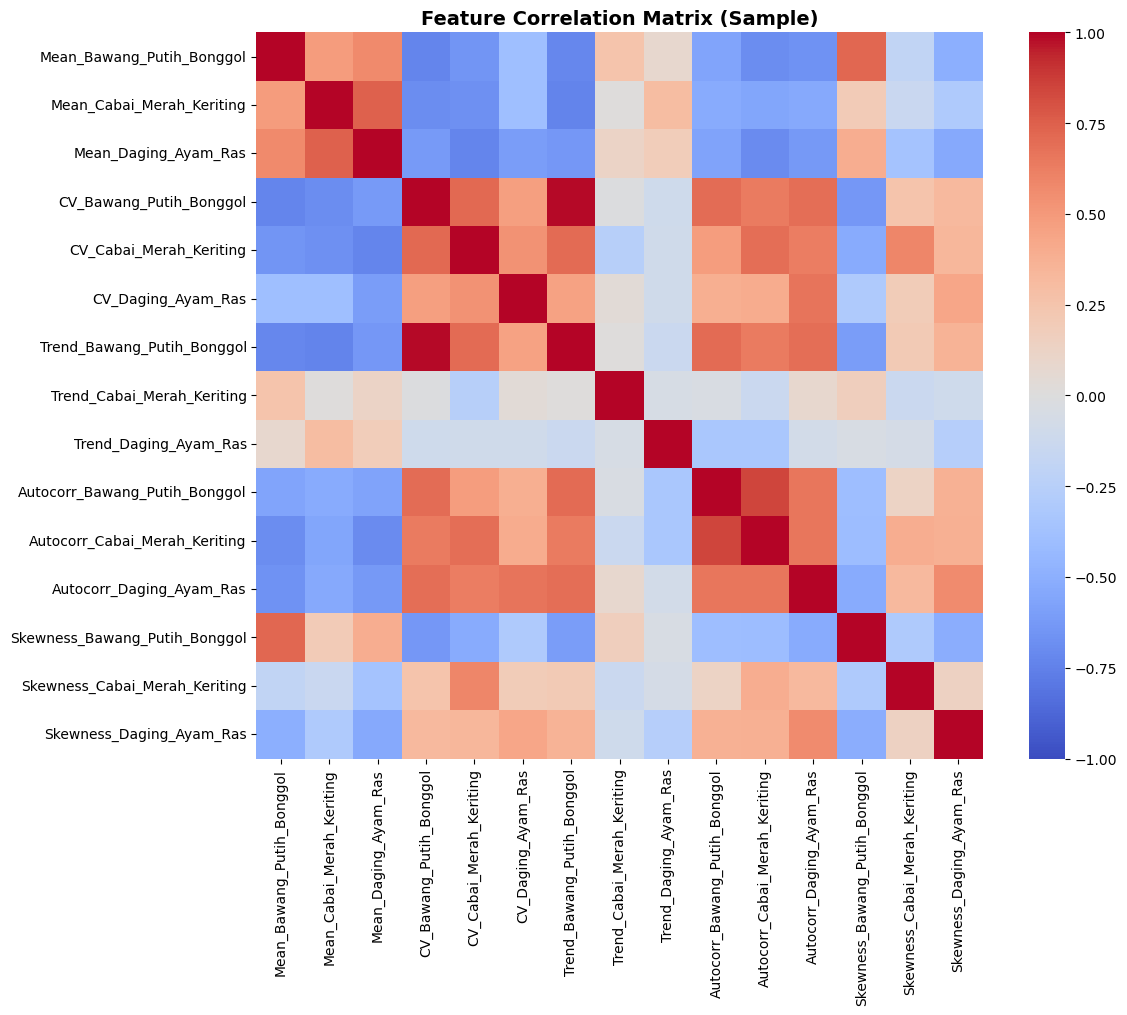


✅ FEATURE VALIDATION COMPLETE!


In [9]:
# ============================================================================
# STEP 6: VISUALIZATION (Optional but good for thesis!)
# ============================================================================
print("\n" + "="*80)
print("GENERATING FEATURE CORRELATION HEATMAP")
print("="*80)

# Sample features for visualization (avoid huge heatmap)
sample_cols = []
for ftype, cols in feature_types.items():
    sample_cols.extend(cols[:3])  # First 3 commodities per type

if len(sample_cols) > 0:
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(df[sample_cols].corr(), annot=False, cmap='coolwarm', 
                center=0, vmin=-1, vmax=1, square=True, ax=ax)
    ax.set_title('Feature Correlation Matrix (Sample)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    plot_file = '/home/kali/AI/feature_correlation_heatmap.png'
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {plot_file}")
    plt.show()

print("\n" + "="*80)
print("✅ FEATURE VALIDATION COMPLETE!")
print("="*80)

In [ ]:
s